In [13]:
import os
from glob import glob

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Cleaning Up (& Stats About It)


 - For each annotator:
   - How many annotation files?
   - How many txt files?
   - Number of empty .ann files
   - How many non-empty .ann files have a `TranscriptionError_Document`/`DuplicatePage` tag?
   - How many .ann files have ONLY one of those two tags and are empty o/w? -> remove if so
   
   => remove corresponding .txt files  
   => create new corpus

In [14]:
def get_all_files(annotator):
    """ collapsing folder structure per annotator"""
    data_dir = "../data/"
    ann_dir = data_dir+annotator+"/"
    for cur_dir in glob(ann_dir+"/6*"):
        txt_files = sorted(glob(cur_dir+"/*.txt"))
        ann_files = sorted(glob(cur_dir+"/*.ann"))
        yield from zip(txt_files, ann_files)
        
        
def has_error_tag(any_string):
    """Return strings with error tags"""
    return "TranscriptionError_Document" in any_string or\
                "DuplicatePage" in any_string


def remove_error_tag_lines(ann_file_content):
    return [line for line in ann_file_content.strip().split("\n") 
             if not has_error_tag(line)] 

In [15]:
annotators = "Bert  Emma  Jonas  Roos  Silja Yolien".split()

In [16]:
results = {}

print("Total Annotation Files Per Annotator\n")
for anno in annotators:
    empty = []
    cur_keep = []

    error_tag = []
    error_tag_but_non_empty = []

    ann_files = list(get_all_files(anno))
    print(anno, len(ann_files))

    for txt, ann in ann_files:
        with open(ann) as handle:
            contents = handle.read()
            
            if not contents.strip():
                empty.append((txt, ann))  
            elif has_error_tag(contents):
                
                error_tags_removed = remove_error_tag_lines(
                                contents
                        )
                
                if error_tags_removed == []:
                    error_tag.append((txt, ann))
                else:
                    error_tag_but_non_empty.append((txt, ann))                
            else:
                cur_keep.append((txt, ann))
                
    
    results[anno] = [cur_keep, empty, error_tag, error_tag_but_non_empty]
    

Total Annotation Files Per Annotator

Bert 808
Emma 983
Jonas 983
Roos 1183
Silja 983
Yolien 983


In [17]:
from tabulate import tabulate

stats = pd.DataFrame([
    [k, sum(map(len, v))]+
    [len(v[0])+len(v[-1])]+
    list(map(len, v)) for k, v in results.items()
    
],
columns=["Annotator", "Total", "Keep",
         "Non-empty-No error", "Empty", "Error", "Err.&Non-Empty"]).set_index("Annotator")
print(stats)

           Total  Keep  Non-empty-No error  Empty  Error  Err.&Non-Empty
Annotator                                                               
Bert         808    86                  75    721      1              11
Emma         983   333                 237    637     13              96
Jonas        983   321                 205    648     14             116
Roos        1183   727                 449    294    162             278
Silja        983   539                 263    346     98             276
Yolien       983   570                 253    388     25             317


<AxesSubplot:xlabel='Annotator', ylabel='Number'>

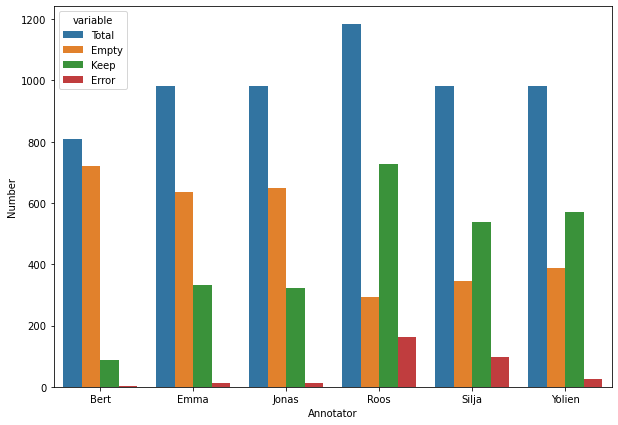

In [18]:
stats_T = pd.melt(stats[["Total", "Empty", "Keep", "Error"]].reset_index(), 
                  id_vars=["Annotator"], value_name="Number")

plt.figure(figsize=(10, 7))
sns.barplot(data=stats_T, x='Annotator', y="Number", hue="variable")

In [19]:
keep = {anno: v[0]+v[-1] for anno, v in results.items()}

{k: len(v) for k, v in keep.items()}

{'Bert': 86,
 'Emma': 333,
 'Jonas': 321,
 'Roos': 727,
 'Silja': 539,
 'Yolien': 570}

In [20]:
# keep

### Make New Corpus

by copying files

In [21]:
from shutil import copy2

already_copied = True

if not already_copied:
    from tqdm import tqdm 
    os.makedirs('Keep')

    for anno, ls in tqdm(keep.items()):
        cur_dir = f"Keep/{anno}"
        os.makedirs(cur_dir)

        for txt, ann in ls:
            copy2(txt, cur_dir)
            copy2(ann, cur_dir)
else:
    print("Already copied, doing nothing!")

Already copied, doing nothing!


# Pairwise Intersections of Annotation Files

In [22]:
def only_names(file_list):
    "returns only names of files in a particular list"
    return [ann.split("/")[-1] for txt, ann in file_list]


ls = []
for a1, fs1 in keep.items():
    for a2, fs2 in keep.items():
        if not a1 == a2:
            
            names1, names2 = only_names(fs1), only_names(fs2)
            inter = set(names1) & set(names2) #names of files are identical
            val = len(inter)/len(names1)
            
            total_names1 = only_names(tup for ls in results[a1] for tup in ls)
            total_names2 = only_names(tup for ls in results[a2] for tup in ls)
            
            total_inter = set(total_names1) & set(total_names2)
            total_val = len(total_inter)/len(total_names1)
    
            jacc_val = len(set(names1).intersection(set(names2)))/len(set(names1).union(set(names2)))
            jacc_val_2 = len(set(total_names1).intersection(set(total_names2)))/len(set(total_names1).union(set(total_names2)))
            
            
            
            ls.append([a1, a2, len(inter), val, 
                       len(total_inter), total_val, jacc_val, jacc_val_2])
            
            
inter_stats = pd.DataFrame(ls, 
                           columns=["Anno1", "Anno2", 
                                    "Intersection", "normed_Intersection",
                                   "total_Intersection", "total_normed_Intersection", "Jaccard_distance", "Jaccard_Distance_2"])

In [23]:
# inter_stats

#### Jaccard Distance to Understand Overlap Pages between Annotators

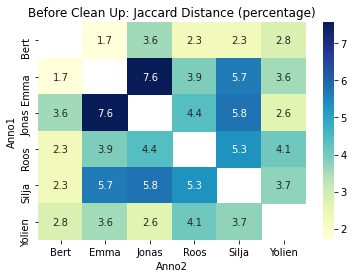

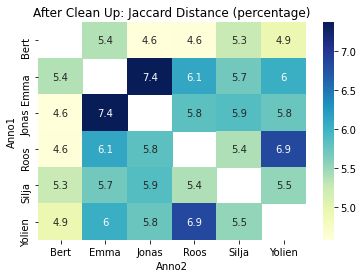

In [30]:
inter_stats_T = inter_stats.pivot_table(
                values="Jaccard_distance",
    index="Anno1", columns="Anno2"
)

sns.heatmap(inter_stats_T*100, annot=True, cmap="YlGnBu")
_ = plt.title("Before Clean Up: Jaccard Distance (percentage)")

plt.show()

inter_stats_T = inter_stats.pivot_table(
                values="Jaccard_Distance_2",
    index="Anno1", columns="Anno2"
)

sns.heatmap(inter_stats_T*100, annot=True, cmap="YlGnBu")
_ = plt.title("After Clean Up: Jaccard Distance (percentage)")

plt.show()


# inter_stats_T = inter_stats.pivot_table(
#                 values="Intersection",
#     index="Anno1", columns="Anno2"
# )

# sns.heatmap(inter_stats_T, 
#             annot=True, cmap="YlGnBu")

# _ = plt.title("Before Clean Up: Raw Counts")

**Conclusion**: Each pair of annotators annotated on average have 6% overlap (over the total documents they annotated together).

## Check Tag Distributions

In [31]:
def get_lines(ann_file):
    with open(ann_file) as handle:
        for l in handle:
            if not l.strip(): continue
            yield l.strip().split("\t")

def get_entities(ann_file):
    for line in get_lines(ann_file):
        if line[0].startswith("T") and len(line) >= 2:
            tag_type, tag, string = line
            yield tag.split()[0]


        
ents = {a: [e for txt, ann in files for e in get_entities(ann)]
       for a, files in keep.items()}

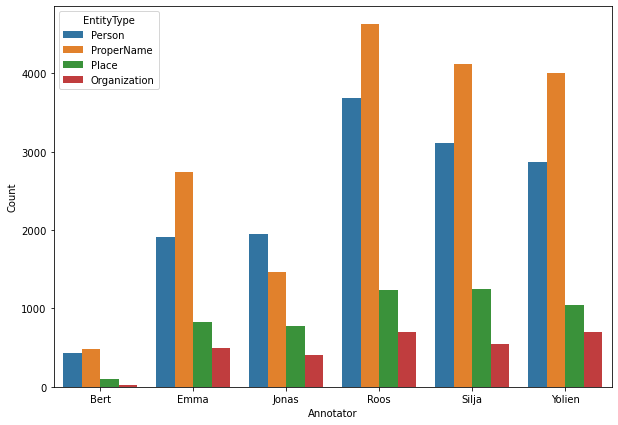

In [32]:
from collections import Counter

entity_stats = pd.DataFrame(
    [[a, e, c] for a in ents for e, c in Counter(ents[a]).items() if not e in ["DuplicatePage", "Noteworthy", "TranscriptionError_Document"]],
    columns=["Annotator", "EntityType", "Count"]
)



plt.figure(figsize=(10, 7))
_ = sns.barplot(data=entity_stats, x='Annotator', y="Count", hue="EntityType")

**Conclusion**: 
Here we see that most annotators follow a similar trend in entities annotated, only annotator who stands out is Jonas.

## Calculation of InterAnnotatorAgreement

4 levels of calculation:
1. Entity
2. Entity and Attributes
3. Entity, Offsets 
4. Entity, Offsets and Attributes